In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


train_data = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/Tinder_Millennial_Match/train_set_label.csv")
test_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/Tinder_Millennial_Match/test_set_label.csv')

In [ ]:
train_data.shape,test_data.shape

((1896, 7), (632, 6))

In [ ]:
train_data.head()

,ID,Segment type,Segment Description,Answer,Count,Percentage,It became a relationship
0,292890.8970,web,"Meridian, Idaho",No,0.000000,0.000000,0
1,292887.9870,web,"Meridian, Idaho",No,0.000000,0.000000,0
2,292894.0656,gender,"Meridian, Idaho",No,499.173606,0.225255,0
3,292887.1180,web,"Meridian, Idaho",No,0.000000,0.000000,0
4,292893.6561,gender,"Meridian, Idaho",No,455.925963,0.211360,0


In [ ]:
train_data=train_data.drop_duplicates()

In [ ]:
test_data['ID'].describe(),train_data['ID'].describe()

(count       632.000000
 mean     293014.301079
 std         247.391468
 min      292881.011200
 25%      292888.377900
 50%      292893.592400
 75%      292945.500000
 max      293779.000000
 Name: ID, dtype: float64, count      1894.000000
 mean     292999.511498
 std         227.901754
 min      292881.000000
 25%      292888.200500
 50%      292893.914450
 75%      292902.574450
 max      293785.000000
 Name: ID, dtype: float64)

In [ ]:
for i in train_data[train_data['ID']>293779].index:
  train_data.drop(i,inplace=True)

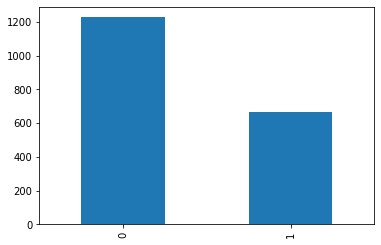

In [ ]:
train_data['It became a relationship'].value_counts().plot(kind='bar')
plt.show()

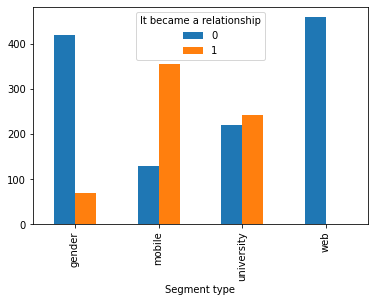

In [ ]:
pd.crosstab(train_data['Segment type'],train_data['It became a relationship']).plot(kind='bar')
plt.show()

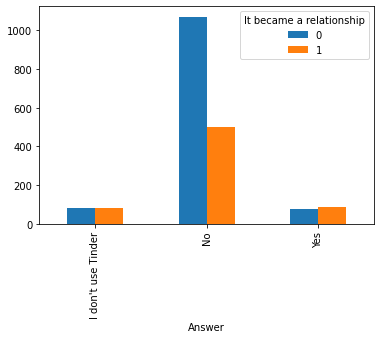

In [ ]:
pd.crosstab(train_data['Answer'],train_data['It became a relationship']).plot(kind='bar')
plt.show()

In [ ]:
combine=train_data.append(test_data)
combine.reset_index(inplace=True)
combine.drop('index',axis=1,inplace=True)
combine.shape

(2523, 7)

In [ ]:
combine.head()

,ID,Segment type,Segment Description,Answer,Count,Percentage,It became a relationship
0,292890.8970,web,"Meridian, Idaho",No,0.000000,0.000000,0.0
1,292887.9870,web,"Meridian, Idaho",No,0.000000,0.000000,0.0
2,292894.0656,gender,"Meridian, Idaho",No,499.173606,0.225255,0.0
3,292887.1180,web,"Meridian, Idaho",No,0.000000,0.000000,0.0
4,292893.6561,gender,"Meridian, Idaho",No,455.925963,0.211360,0.0


In [ ]:
combine.describe()

,ID,Count,Percentage,It became a relationship
count,2523.000000,2523.000000,2523.000000,1891.000000
mean,293002.284605,438.411442,0.252648,0.351137
std,231.549097,493.716960,0.222746,0.477452
min,292881.000000,0.000000,0.000000,0.000000
25%,292888.253400,0.000000,0.000000,0.000000
50%,292893.773300,329.702412,0.255903,0.000000
75%,292902.891950,834.307315,0.396284,1.000000
max,293779.000000,1969.000000,1.000000,1.000000


In [ ]:
X = combine[combine['It became a relationship'].isnull()!=True].drop(['It became a relationship'], axis=1)
y = combine[combine['It became a relationship'].isnull()!=True]['It became a relationship']

test = combine[combine['It became a relationship'].isnull()==True].drop(['It became a relationship'], axis=1)

X.shape, y.shape, test.shape

((1891, 6), (1891,), (632, 6))

In [ ]:
X.head()

,ID,Segment type,Segment Description,Answer,Count,Percentage
0,292890.8970,web,"Meridian, Idaho",No,0.000000,0.000000
1,292887.9870,web,"Meridian, Idaho",No,0.000000,0.000000
2,292894.0656,gender,"Meridian, Idaho",No,499.173606,0.225255
3,292887.1180,web,"Meridian, Idaho",No,0.000000,0.000000
4,292893.6561,gender,"Meridian, Idaho",No,455.925963,0.211360


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=42)

In [ ]:
!pip install catboost

In [ ]:
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
m = CatBoostClassifier(n_estimators=5000,
                           random_state=1994,
                           eval_metric='Accuracy',
                           learning_rate=0.03, 
                           max_depth=5,
                           cat_features=[1,2,3])
m.fit(X_train, y_train,
          eval_set=[(X_train,y_train),(X_test, y_test)],
          early_stopping_rounds=200,
          verbose=200)
accuracy_score(m.predict(X_test),y_test)

0:	learn: 0.8306878	test: 0.8330394	test1: 0.8315789	best: 0.8315789 (0)	total: 53.9ms	remaining: 4m 29s
200:	learn: 0.9564962	test: 0.9888301	test1: 0.9421053	best: 0.9473684 (71)	total: 860ms	remaining: 20.5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9473684211
bestIteration = 71

Shrink model to first 72 iterations.


0.9473684210526315

In [ ]:
errCB = []
y_pred_tot_cb = []
from sklearn.model_selection import StratifiedKFold

fold = StratifiedKFold(n_splits=5)
i = 1
for train_index, test_index in fold.split(X,y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y[train_index], y[test_index]
    m = CatBoostClassifier(n_estimators=5000,
                           random_state=1994,
                           eval_metric='Accuracy',
                           learning_rate=0.03, 
                           max_depth=5,
                           cat_features=[1,2,3])
    m.fit(x_train, y_train,
          eval_set=[(x_train,y_train),(x_val, y_val)],
          early_stopping_rounds=200,
          verbose=200)
    pred_y = m.predict(x_val)
    print("err_cb: ",accuracy_score(pred_y,y_val))
    errCB.append(accuracy_score(pred_y,y_val))
    pred_test = m.predict(test)
    i = i + 1
    y_pred_tot_cb.append(pred_test)

0:	learn: 0.8379630	test: 0.8399471	test1: 0.8284960	best: 0.8284960 (0)	total: 4.84ms	remaining: 24.2s
200:	learn: 0.9589947	test: 0.9907407	test1: 0.9604222	best: 0.9604222 (139)	total: 767ms	remaining: 18.3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9604221636
bestIteration = 139

Shrink model to first 140 iterations.
err_cb:  0.9604221635883905
0:	learn: 0.8274950	test: 0.8195638	test1: 0.8439153	best: 0.8439153 (0)	total: 4.32ms	remaining: 21.6s
200:	learn: 0.9464640	test: 0.9953734	test1: 0.9497354	best: 0.9497354 (59)	total: 732ms	remaining: 17.5s
400:	learn: 0.9656312	test: 0.9920687	test1: 0.9523810	best: 0.9550265 (224)	total: 1.5s	remaining: 17.2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.955026455
bestIteration = 224

Shrink model to first 225 iterations.
err_cb:  0.955026455026455
0:	learn: 0.8341044	test: 0.8380701	test1: 0.8439153	best: 0.8439153 (0)	total: 4.26ms	remaining: 21.3s
200:	learn: 0.9491077	test: 0.9894250

In [ ]:
np.mean(errCB,0)

0.9598093004425458

In [ ]:
submission=pd.DataFrame()
submission['prediction']=np.where(np.mean(y_pred_tot_cb,0)>0.5,1,0)
submission.to_csv('final.csv',index=False)